In [9]:
import pandas as pd
import seaborn as se
import pickle
from collections import Counter
import numpy as np
import os
import pickle
from timeit import timeit
import json
from timeit import default_timer as timer
from pathlib import Path
import shutil
import math
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm
import matplotlib.ticker as mtick

In [10]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)
se.set_style("darkgrid")

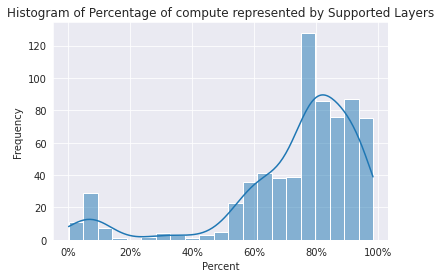

In [11]:

plt = se.histplot(x = arch_metrics["percent_of_compute"].groupby(level=0).sum().multiply(100), kde=True)
plt.set_title('Histogram of Percentage of compute represented by Supported Layers')
plt.set_xlabel('Percent')
plt.set_ylabel('Frequency')
plt.xaxis.set_major_formatter(mtick.PercentFormatter())
# present as CDF and Histogram

Text(0.5, 1.0, 'Accelerator Speedup Factor Over CPU Baseline')

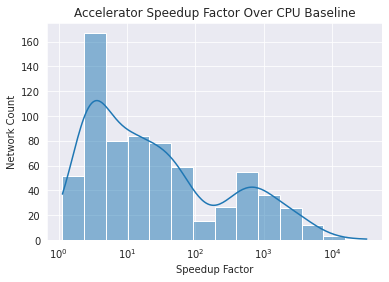

In [12]:
plt = se.histplot(x = arch_metrics['speedup'].groupby(level=0).mean(), log_scale=True, kde=True)
plt.set_xscale('log', base=10)
plt.set_xlabel('Speedup Factor')
plt.set_ylabel('Network Count')
plt.set_title('Accelerator Speedup Factor Over CPU Baseline')

Text(0.5, 1.0, 'Inferences/J')

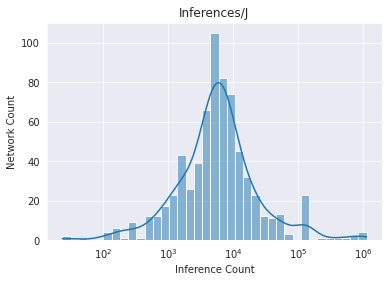

In [13]:
inferences_per_joule = arch_metrics.groupby(level = 0).mean().loc[:, ~arch_metrics.columns.isin(['latency', 'load_bw', 'store_bw', 'speedup', 'percent_of_compute', 'util'])].sum(axis = 1).pow(-1)
plt = se.histplot(inferences_per_joule, log_scale=True, kde=True)
plt.set_xscale('log', base=10)
plt.set_xlabel('Inference Count')
plt.set_ylabel('Network Count')
plt.set_title('Inferences/J')


In [14]:
energy_per_inference = arch_metrics.groupby(level = 0).mean().loc[:, ~arch_metrics.columns.isin(['latency', 'load_bw', 'store_bw', 'speedup', 'percent_of_compute', 'util'])]
energy_per_inference.mean()

dram_energy                5.922364e-04
ifmap_sram_energy          8.934231e-07
psum_sram_energy           2.531178e-07
reuse_chain_sram_energy    2.999377e-08
weight_sram_energy         1.475684e-07
mac_energy                 7.341871e-17
dtype: float64

In [15]:
5.922364e-04 / 8.934231e-07

662.8845840229562

Text(0.5, 1.0, 'Bandwidth distribution')

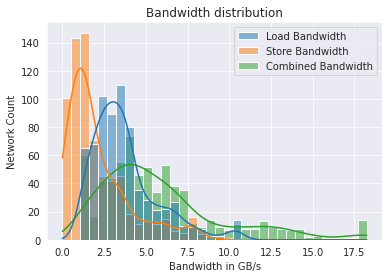

In [16]:
bw_df = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['load_bw', 'store_bw'])].div(2**30)
bw_df["combined"] = bw_df["load_bw"] + bw_df["store_bw"]
bw_df = bw_df.rename(columns={'load_bw': "Load Bandwidth", "store_bw": "Store Bandwidth", "combined":"Combined Bandwidth"})
plt = se.histplot(data = bw_df, kde=True)
plt.set_xlabel('Bandwidth in GB/s')
plt.set_ylabel('Network Count')
plt.set_title('Bandwidth distribution')

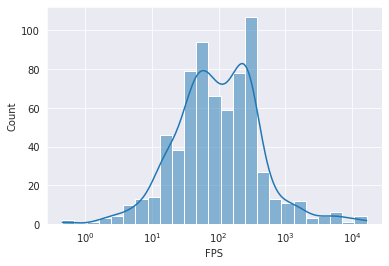

In [17]:
fps = arch_metrics.groupby(level = 0).sum().loc[:, arch_metrics.columns.isin(['latency'])].mul(1*10**-9).pow(-1)
fps = fps.rename(columns={"latency": "FPS"})
plt = se.histplot(data = fps, x = "FPS", kde=True, log_scale=True)

Text(0.5, 1.0, 'Utilization distribution')

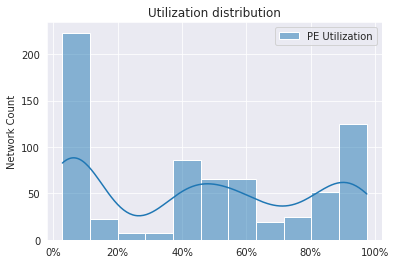

In [70]:
util = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['util'])].mul(100)
util = util.rename(columns={"util": "PE Utilization"})
plt = se.histplot(data = util, kde=True)
plt.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.set_ylabel('Network Count')
plt.set_title('Utilization distribution')

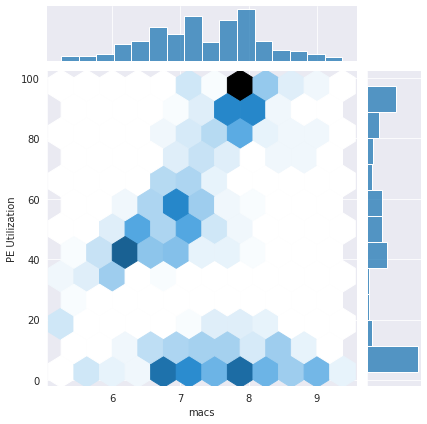

In [163]:
layer_properties = pd.read_csv('../data/layer_properties.csv', index_col=[0, 1])
layer_properties['macs'] = np.log10(layer_properties['macs'])
macs_vs_util_df = pd.DataFrame(layer_properties['macs'].groupby(level=0).mean()).join(util)
plt = se.jointplot(data = macs_vs_util_df, x='macs', y='PE Utilization', kind="hex")

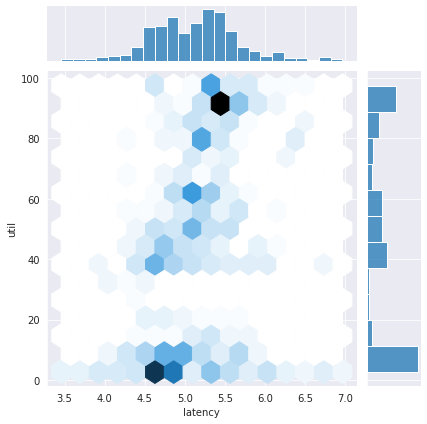

In [222]:
latency = arch_metrics[['latency']].groupby(level=0).mean()
latency = np.log10(latency)
latency_vs_util = latency.join(arch_metrics[['util']].groupby(level=0).mean().mul(100))
plt = se.jointplot(data = latency_vs_util, x='latency', y='util', kind="hex")

In [ ]:
speedup = arch_metrics[['speedup']].groupby(level=0).mean()
speedup = np.log10(speedup)
speedup_vs_util = speedup.join(arch_metrics[['util']].groupby(level=0).mean().mul(100))
plt = se.jointplot(data = speedup_vs_util, x='speedup', y='util', kind="hex")

In [ ]:
layer_properties = pd.read_csv('../data/layer_properties.csv', index_col=[0, 1])
util = arch_metrics['util']
speedup = arch_metrics['speedup']
slow_layers_with_low_util = arch_metrics[['util', 'speedup']][(util < 0.1) & (speedup < 1)]
slow_layer_properties = layer_properties[layer_properties.index.isin(slow_layers_with_low_util.index)]
slow_layer_properties.loc[:, 'total_mem_size'] = np.log2(slow_layer_properties['ifmap_mem_size'] + slow_layer_properties['ofmap_mem_size'])
slow_layer_properties.loc[:, 'util'] = slow_layers_with_low_util['util'].mul(100)
plt = se.jointplot(data = slow_layer_properties, x='total_mem_size', y='util', kind="hex")


In [119]:
from get_unique_layers_within_models import ConvLayer, LinearLayer
with open("../data/model_unique_layers_tracker.pickle", "rb") as file:
    model_unique_layers_tracker = pickle.load(file)

100%|██████████| 716/716 [01:38<00:00,  7.31it/s]
695it [01:38,  7.09it/s]


Text(0.5, 1.0, 'Per Layer Speedup vs CPU Baseline for mobilenetv3_small_075')

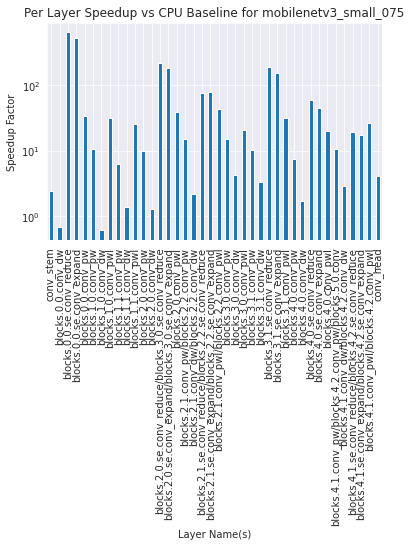

In [130]:
model_name = "mobilenetv3_small_075"
combined_model_metrics = {}
for group_idx, layer_names in model_unique_layers_tracker[model_name].items():
    group_metrics = arch_metrics.loc[([model_name],layer_names), : ].mean()
    combined_layer_names = '/'.join(layer_names)
    combined_model_metrics[combined_layer_names] = group_metrics.to_dict()
combined_model_df = pd.DataFrame.from_dict(combined_model_metrics, orient='index')
plt = combined_model_df.loc[:, 'speedup'].plot(kind='bar')
plt.set_yscale('log', base=10)
plt.set_ylabel('Speedup Factor')
plt.set_xlabel('Layer Name(s)')
plt.set_title(f"Per Layer Speedup vs CPU Baseline for {model_name}")

Text(0, 0.5, 'Energy in Joules')

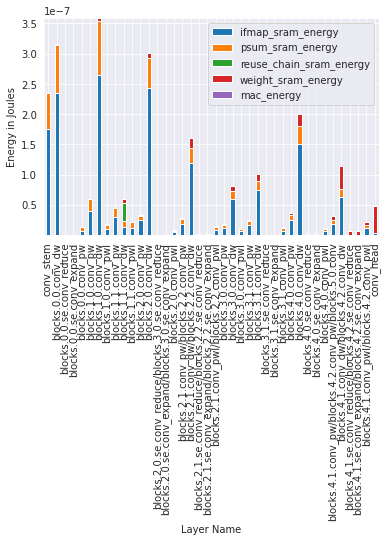

In [128]:

combined_model_metrics = {}
for group_idx, layer_names in model_unique_layers_tracker[model_name].items():
    group_metrics = arch_metrics.loc[([model_name],layer_names), : ].mean()
    combined_layer_names = '/'.join(layer_names)
    combined_model_metrics[combined_layer_names] = group_metrics.to_dict()
combined_model_df = pd.DataFrame.from_dict(combined_model_metrics, orient='index')

plt = combined_model_df.loc[:, ["ifmap_sram_energy", "psum_sram_energy", "reuse_chain_sram_energy", "weight_sram_energy", "mac_energy"]].plot(kind='bar', stacked=True)
# plt.set_yscale('log', base=10)
plt.set_xlabel('Layer Name')
plt.set_ylabel('Energy in Joules')

Text(0, 0.5, 'Utilization percentage')

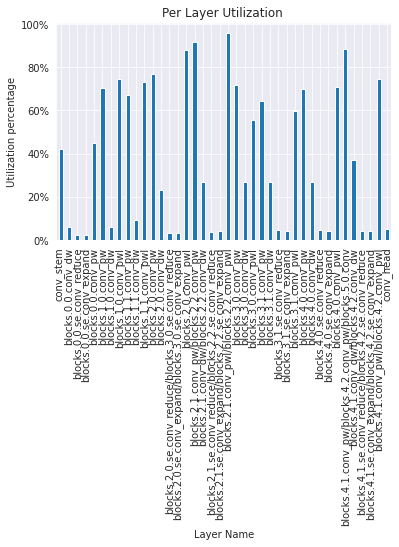

In [131]:
plt = combined_model_df.loc[:, 'util'].mul(100).plot(kind='bar')
plt.set_title("Per Layer Utilization ")
plt.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.set_xlabel('Layer Name')
plt.set_ylabel('Utilization percentage')